In [663]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import minimize
from scipy.stats import skew
from scipy.stats import kurtosis
import os
import datetime
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

In [664]:
df = pd.read_csv('A2_data.csv', index_col=0)
df.head()

,S&P,T_Bill,T_Bond,Corporate_Bond,Housing,Inflation
Year,,,,,,
1928,0.438,0.031,0.008,0.032,0.015,-0.012
1929,-0.083,0.032,0.042,0.030,-0.021,0.000
1930,-0.251,0.045,0.045,0.005,-0.043,-0.027
1931,-0.438,0.023,-0.026,-0.157,-0.082,-0.089
1932,-0.086,0.011,0.088,0.236,-0.105,-0.103


In [665]:
def nominal_to_real_return(nominal_rate, inflation):
    '''
    convert nominal returns to real returns
    '''
    return np.divide((1 + nominal_rate), (1 + inflation)) - 1

def excess_return(risky_returns, risk_free_returns):
    return np.subtract(risky_returns, risk_free_returns)

def Sharpe_Ratio(excess_returns):
    '''
    Calculate Sharpe Ratio for individual asset
    '''
    return excess_returns.mean() / excess_returns.std()

def return_summary_table(returns):
    df_summary = returns.describe().loc[['mean', 'std', 'min', 'max'], :]
    df_summary.index = ['Mean', 'Std', 'Min', 'Max']

    # calculate skewness
    skew = returns.skew()
    skew.name = 'Skewness'

    # calculate kurtosis
    kurt = returns.kurt()
    kurt.name = 'Kurtosis'

    # calculate lag 1 autocorrelation coeffients
    acfs = {}
    for i in range(len(returns.columns)):
        asset = returns.columns[i]
        acfs[asset] = acf(returns.dropna()[asset], fft=False, nlags=1)[1]
    
    acfs_series = pd.Series(acfs, name='Autocorrelation_1')
    
    df_summary = df_summary.append([kurt, skew, acfs_series])
    
    return df_summary


# 1) Assets Returns (Nominal)

In [666]:
# nominal returns
nominal_returns = df.iloc[:, :-1]
inflations = df[['Inflation']]
nominal_returns.head()

,S&P,T_Bill,T_Bond,Corporate_Bond,Housing
Year,,,,,
1928,0.438,0.031,0.008,0.032,0.015
1929,-0.083,0.032,0.042,0.030,-0.021
1930,-0.251,0.045,0.045,0.005,-0.043
1931,-0.438,0.023,-0.026,-0.157,-0.082
1932,-0.086,0.011,0.088,0.236,-0.105


In [667]:
# excess nominal returns
excess_nominal_returns = excess_return(risky_returns=nominal_returns.drop(columns='T_Bill'),
                                    risk_free_returns=nominal_returns[['T_Bill']])
excess_nominal_returns.head()

,S&P,T_Bond,Corporate_Bond,Housing
Year,,,,
1928,0.407,-0.022,0.001,-0.016
1929,-0.115,0.010,-0.001,-0.052
1930,-0.297,-0.000,-0.040,-0.088
1931,-0.461,-0.049,-0.180,-0.105
1932,-0.097,0.077,0.225,-0.115


In [668]:
# nominal returns summary statistics
return_summary_table(nominal_returns)

,S&P,T_Bill,T_Bond,Corporate_Bond,Housing
Mean,0.116,0.034,0.051,0.072,0.042
Std,0.196,0.030,0.077,0.076,0.062
Min,-0.438,0.000,-0.111,-0.157,-0.120
Max,0.526,0.140,0.328,0.291,0.241
Kurtosis,0.087,0.901,1.721,0.629,1.304
Skewness,-0.415,1.017,1.007,0.290,0.325
Autocorrelation_1,-0.008,0.921,-0.073,0.166,0.686


In [669]:
# correlation matrix for nominal returns
nominal_returns.drop(columns='T_Bill').corr()

,S&P,T_Bond,Corporate_Bond,Housing
S&P,1.000,-0.015,0.405,0.137
T_Bond,-0.015,1.000,0.591,-0.087
Corporate_Bond,0.405,0.591,1.000,-0.020
Housing,0.137,-0.087,-0.020,1.000


In [670]:
# excess nominal returns summary statistics
return_summary_table(excess_nominal_returns)

,S&P,T_Bond,Corporate_Bond,Housing
Mean,0.082,0.017,0.038,0.008
Std,0.199,0.074,0.079,0.065
Min,-0.461,-0.144,-0.180,-0.134
Max,0.516,0.222,0.232,0.237
Kurtosis,0.002,0.349,0.205,1.642
Skewness,-0.318,0.375,-0.079,0.785
Autocorrelation_1,0.002,-0.140,0.179,0.705


In [671]:
# correlation matrix for excess nominal returns
excess_nominal_returns.corr()

,S&P,T_Bond,Corporate_Bond,Housing
S&P,1.000,0.016,0.439,0.195
T_Bond,0.016,1.000,0.597,-0.074
Corporate_Bond,0.439,0.597,1.000,0.075
Housing,0.195,-0.074,0.075,1.000


In [672]:
# Sharpe Ratio for nominal returns
sp_nominal = Sharpe_Ratio(excess_nominal_returns)

# Part 1) Portfolios with Stocks and T-Bond (Nominal returns)

In [673]:
weights_stock = np.linspace(0, 1, 11)
weights_bond = 1 - weights_stock
weights = np.vstack((weights_stock, weights_bond))
# 2 * 11 matrix
weights

array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       [1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]])

In [674]:
# 92 * 2 matrix
excess_nominal_returns[['S&P', 'T_Bond']].shape

(92, 2)

In [675]:
# matrix multiplication
port_returns_nominal = excess_nominal_returns[['S&P', 'T_Bond']].dot(weights) # 92 * 11 matrix
port_returns_nominal.columns = [f'{i}%_Stock' for i in range(0, 110, 10)]
port_returns_nominal.head().style.format('{:.2%}')

,0%_Stock,10%_Stock,20%_Stock,30%_Stock,40%_Stock,50%_Stock,60%_Stock,70%_Stock,80%_Stock,90%_Stock,100%_Stock
Year,,,,,,,,,,,
1928,-2.24%,2.05%,6.35%,10.65%,14.95%,19.24%,23.54%,27.84%,32.14%,36.43%,40.73%
1929,1.04%,-0.21%,-1.46%,-2.71%,-3.96%,-5.21%,-6.46%,-7.71%,-8.96%,-10.21%,-11.46%
1930,-0.01%,-2.98%,-5.94%,-8.91%,-11.87%,-14.84%,-17.81%,-20.77%,-23.74%,-26.71%,-29.67%
1931,-4.87%,-9.00%,-13.12%,-17.25%,-21.38%,-25.51%,-29.64%,-33.76%,-37.89%,-42.02%,-46.15%
1932,7.72%,5.98%,4.23%,2.49%,0.75%,-1.00%,-2.74%,-4.48%,-6.23%,-7.97%,-9.71%


In [676]:
# summary statistics for portfolios
return_summary_table(port_returns_nominal)

,0%_Stock,10%_Stock,20%_Stock,30%_Stock,40%_Stock,50%_Stock,60%_Stock,70%_Stock,80%_Stock,90%_Stock,100%_Stock
Mean,0.017,0.024,0.030,0.037,0.043,0.050,0.056,0.062,0.069,0.075,0.082
Std,0.074,0.070,0.072,0.080,0.092,0.107,0.124,0.141,0.160,0.179,0.199
Min,-0.144,-0.120,-0.131,-0.173,-0.214,-0.255,-0.296,-0.338,-0.379,-0.420,-0.461
Max,0.222,0.210,0.207,0.221,0.235,0.270,0.319,0.368,0.418,0.467,0.516
Kurtosis,0.349,0.114,-0.085,-0.139,-0.113,-0.075,-0.047,-0.028,-0.015,-0.005,0.002
Skewness,0.375,0.255,0.055,-0.124,-0.233,-0.286,-0.309,-0.317,-0.320,-0.320,-0.318
Autocorrelation_1,-0.140,-0.097,-0.044,-0.004,0.015,0.021,0.019,0.015,0.011,0.006,0.002


In [677]:
# portfolio sharpe ratios
Sharpe_Ratio(port_returns_nominal)

0%_Stock     0.235
10%_Stock    0.341
20%_Stock    0.421
30%_Stock    0.460
40%_Stock    0.470
50%_Stock    0.465
60%_Stock    0.454
70%_Stock    0.442
80%_Stock    0.430
90%_Stock    0.420
100%_Stock   0.411
dtype: float64

# Part 2) Asset Returns (Real)

In [678]:
# real returns
real_returns = nominal_to_real_return(nominal_rate=nominal_returns, inflation=inflations)
real_returns.head()

,S&P,T_Bill,T_Bond,Corporate_Bond,Housing
Year,,,,,
1928,0.455,0.043,0.020,0.044,0.027
1929,-0.083,0.032,0.042,0.030,-0.021
1930,-0.231,0.074,0.074,0.033,-0.017
1931,-0.383,0.123,0.070,-0.074,0.009
1932,0.018,0.127,0.213,0.378,-0.002


In [679]:
# excess real returns
excess_real_returns = excess_return(risky_returns=real_returns.drop(columns='T_Bill'),
                                    risk_free_returns=real_returns[['T_Bill']])
excess_real_returns.head()

,S&P,T_Bond,Corporate_Bond,Housing
Year,,,,
1928,0.412,-0.023,0.001,-0.016
1929,-0.115,0.010,-0.001,-0.052
1930,-0.305,-0.000,-0.041,-0.091
1931,-0.507,-0.053,-0.198,-0.115
1932,-0.108,0.086,0.251,-0.129


In [680]:
# real returns summary statistics
return_summary_table(real_returns)

,S&P,T_Bill,T_Bond,Corporate_Bond,Housing
Mean,0.084,0.004,0.022,0.042,0.011
Std,0.196,0.036,0.081,0.086,0.050
Min,-0.389,-0.121,-0.146,-0.149,-0.152
Max,0.582,0.127,0.251,0.378,0.147
Kurtosis,0.084,3.585,0.326,1.782,1.451
Skewness,-0.165,0.005,0.519,0.565,-0.055
Autocorrelation_1,-0.025,0.716,0.056,0.220,0.549


In [681]:
# correlation matrix for real returns
real_returns.drop(columns='T_Bill').corr()

,S&P,T_Bond,Corporate_Bond,Housing
S&P,1.000,0.055,0.437,0.182
T_Bond,0.055,1.000,0.669,-0.075
Corporate_Bond,0.437,0.669,1.000,0.080
Housing,0.182,-0.075,0.080,1.000


In [682]:
# excess real returns summary statistics
return_summary_table(excess_real_returns)

,S&P,T_Bond,Corporate_Bond,Housing
Mean,0.080,0.017,0.038,0.007
Std,0.197,0.072,0.078,0.063
Min,-0.507,-0.127,-0.198,-0.129
Max,0.517,0.209,0.251,0.219
Kurtosis,0.242,0.269,0.552,1.262
Skewness,-0.317,0.382,-0.015,0.625
Autocorrelation_1,0.013,-0.154,0.156,0.712


In [683]:
# correlation matrix for excess real returns
excess_real_returns.corr()

,S&P,T_Bond,Corporate_Bond,Housing
S&P,1.000,0.015,0.443,0.209
T_Bond,0.015,1.000,0.584,-0.074
Corporate_Bond,0.443,0.584,1.000,0.071
Housing,0.209,-0.074,0.071,1.000


In [684]:
# Sharpe Ratio for real returns
sp_real = Sharpe_Ratio(excess_real_returns)

pd.DataFrame({'Sharpe_Nominal':sp_nominal, 'Sharpe_Real':sp_real})

,Sharpe_Nominal,Sharpe_Real
S&P,0.411,0.406
T_Bond,0.235,0.242
Corporate_Bond,0.485,0.487
Housing,0.119,0.109


# Part 2) Portfolios with Stocks and T-Bond (Real returns)

In [685]:
# matrix multiplication (using weights from part 1)
port_returns_real = excess_real_returns[['S&P', 'T_Bond']].dot(weights) # 92 * 11 matrix
port_returns_real.columns = [f'{i}%_Stock' for i in range(0, 110, 10)]
port_returns_real.head().style.format('{:.2%}')

,0%_Stock,10%_Stock,20%_Stock,30%_Stock,40%_Stock,50%_Stock,60%_Stock,70%_Stock,80%_Stock,90%_Stock,100%_Stock
Year,,,,,,,,,,,
1928,-2.27%,2.08%,6.42%,10.77%,15.12%,19.47%,23.82%,28.16%,32.51%,36.86%,41.21%
1929,1.04%,-0.21%,-1.46%,-2.71%,-3.96%,-5.21%,-6.46%,-7.71%,-8.96%,-10.21%,-11.46%
1930,-0.01%,-3.06%,-6.11%,-9.15%,-12.20%,-15.25%,-18.30%,-21.34%,-24.39%,-27.44%,-30.49%
1931,-5.35%,-9.88%,-14.41%,-18.94%,-23.48%,-28.01%,-32.54%,-37.08%,-41.61%,-46.14%,-50.67%
1932,8.61%,6.66%,4.72%,2.78%,0.83%,-1.11%,-3.05%,-5.00%,-6.94%,-8.88%,-10.83%


In [686]:
# summary statistics for portfolios
return_summary_table(port_returns_real)

,0%_Stock,10%_Stock,20%_Stock,30%_Stock,40%_Stock,50%_Stock,60%_Stock,70%_Stock,80%_Stock,90%_Stock,100%_Stock
Mean,0.017,0.024,0.030,0.036,0.042,0.049,0.055,0.061,0.067,0.074,0.080
Std,0.072,0.068,0.070,0.078,0.090,0.105,0.122,0.140,0.158,0.177,0.197
Min,-0.127,-0.114,-0.144,-0.189,-0.235,-0.280,-0.325,-0.371,-0.416,-0.461,-0.507
Max,0.209,0.197,0.202,0.215,0.228,0.269,0.318,0.367,0.416,0.466,0.517
Kurtosis,0.269,0.056,-0.060,0.002,0.111,0.187,0.225,0.242,0.246,0.245,0.242
Skewness,0.382,0.247,0.031,-0.154,-0.258,-0.304,-0.321,-0.325,-0.324,-0.321,-0.317
Autocorrelation_1,-0.154,-0.106,-0.045,0.001,0.024,0.031,0.031,0.027,0.022,0.018,0.013


In [687]:
# summary statistics for portfolios
Sharpe_Ratio(port_returns_real)

0%_Stock     0.242
10%_Stock    0.348
20%_Stock    0.426
30%_Stock    0.462
40%_Stock    0.469
50%_Stock    0.462
60%_Stock    0.450
70%_Stock    0.437
80%_Stock    0.426
90%_Stock    0.415
100%_Stock   0.406
dtype: float64

# Part 3) Efficient Frontiers

In [688]:
def port_variance(weights, asset_returns):
    '''
    Calculate Portfolio expected variance
    '''
    assert weights.ndim == 1, 'weights should be a vector (1 d array)'
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    
    covariance_matrix = asset_returns.cov()
    #print(covariance_matrix)
    return weights.dot(covariance_matrix).dot(weights)

def port_mean(weights, asset_returns):
    '''
    Calculate Portfolio expected mean return
    '''
    assert weights.ndim == 1, 'weights should be a vector (1 d array)'
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    
    return np.mean(weights.dot(asset_returns.T))

def port_skewness(weights, asset_returns):
    '''
    Calculate Portfolio expected skewness
    '''
    assert weights.ndim == 1, 'weights should be a vector (1 d array)'
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    
    return skew(weights.dot(asset_returns.T))

def port_kurtosis(weights, asset_returns):
    '''
    Calculate Portfolio expected kurtosis
    '''
    assert weights.ndim == 1, 'weights should be a vector (1 d array)'
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    
    return kurtosis(weights.dot(asset_returns.T))

def port_sharpe_ratio(weights, asset_returns):
    '''
    Calculate Portfolio Sharpe Ratio
    '''
    return (port_mean(weights, asset_returns) / np.sqrt(port_variance(weights, asset_returns)))


def constr_port_mean(weights, asset_returns, target_return):
    '''
    Constraint function as input for scipy.optimize.minimize
    '''
    assert weights.ndim == 1, 'weights should be a vector (1 d array)'
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    
    return np.mean(weights.dot(asset_returns.T)) - target_return

def obj_port_variance(partial_weights, asset_returns):
    '''
    objective function fed into scipy.optimize.minimize()
    '''
    assert partial_weights.ndim == 1, 'weights should be a vector (1 d array)'
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    assert partial_weights.shape[0] == asset_returns.shape[1] - 1, "you don't need the last weight as decision variable"
    
    covariance_matrix = asset_returns.cov()
    weights = np.hstack((partial_weights, (1-np.sum(partial_weights))))
    #print(covariance_matrix)
    return weights.dot(covariance_matrix).dot(weights)

def obj_neg_port_sharpe_ratio(partial_weights, asset_returns):
    '''
    objective function fed into scipy.optimize.minimize()
    '''
    weights = np.hstack((partial_weights, (1-np.sum(partial_weights))))
    return (port_mean(weights, asset_returns) / np.sqrt(port_variance(weights, asset_returns))) * -1


def minimize_port_variance(initial_weights, asset_returns):
    '''
    uses scipy.optimize.minimize() to find minimum variance portfolio
    '''
    return minimize(fun=obj_port_variance, x0=initial_weights, args=(asset_returns,))

def maximize_sharpe_ratio(initial_weights, asset_returns):
    '''
    uses scipy.optimize.minimize() to find tangency portfolio
    '''
    return minimize(fun=obj_neg_port_sharpe_ratio, x0=initial_weights, args=(asset_returns,))

def efficient_port(asset_returns, minimize_variance=True):
    '''
    returns 4 moments of either a minimum variance portfolio or a tangency portfolio
    '''
    n_assets = asset_returns.shape[1]
    initial_weights = np.repeat(1/n_assets, n_assets-1)
    
    if minimize_variance:
        port = minimize_port_variance(initial_weights, asset_returns)
    else: 
        port = maximize_sharpe_ratio(initial_weights, asset_returns)
    #print(port)
    optimal_weights = np.hstack((port['x'], 1-port['x'].sum()))
    print(optimal_weights)
    print('')
    return pd.Series({'Mean':port_mean(optimal_weights, asset_returns),
                     'Std':np.sqrt(port_variance(optimal_weights, asset_returns)),
                     'Skewness':port_skewness(optimal_weights, asset_returns),
                     'Kurtosis':port_kurtosis(optimal_weights, asset_returns),
                     'Weights':optimal_weights})
    

def linear_comb_weights(two_fund_weights, n_portfolios):
    '''
    Construct n number of efficient portfolio based on two efficient portfolios (Two-fund-Separation)
    two_fund_weights: a 2 * m matrix (m is the number of assets in a portfolio)
    returns: a n * m weights matrix (n is the number of efficient portfolios generated)
    '''
    assert two_fund_weights.shape[0] == 2, 'two_fund_weights must be weights of two portfolios'
    assert two_fund_weights.ndim == 2, 'two_fund_weights must be a 2 d array'
    
    n_assets = two_fund_weights.shape[1]
    temp_matrix = np.random.uniform(-1, 2, (n_portfolios, 1))
    
    return np.hstack((temp_matrix, (1-temp_matrix))).dot(two_fund_weights)

def efficient_frontier(asset_returns, n_portfolios=20):
    '''
    Compute an efficient frontier based on two fund separation theorem
    the two funds are minimum variance portfolio and tangency portfolio
    returns a dictionary which stores lists of means and stds from generated efficient portfolios, and 
    also info of minimum variance portfolio and tangency portfolio
    
    n is the number of efficient portfolios generated
    m is the number of assets in a portfolio
    '''
    assert asset_returns.ndim == 2, 'asset returns matrix should be a 2 d array'
    
    n_assets = asset_returns.shape[1]
    initial_weights = np.repeat(1/n_assets, n_assets-1) # note we only set up (m - 1) decision variables 
    
    # obtain minimum variance portfolio
    min_var_port = minimize_port_variance(initial_weights, asset_returns)
    
    # obtain maximum sharpe ratio portfolio
    max_sharpe_port = maximize_sharpe_ratio(initial_weights, asset_returns)
    
    # the two fund weights matrix
    optimal_weights_min_var = np.hstack((min_var_port['x'], 1-min_var_port['x'].sum()))
    optimal_weights_max_sharpe = np.hstack((max_sharpe_port['x'], 1-max_sharpe_port['x'].sum()))
    
    two_fund_weights = np.vstack((optimal_weights_min_var, optimal_weights_max_sharpe))# 2 * m matrix (m is the number of assets in a portfolio)
    
    # two fund separations: obtain linear combinations of the two efficient portfolios
    W = linear_comb_weights(two_fund_weights, n_portfolios) # generate efficient portfolio weights: a m * n matrix
    
    std_list = []
    mean_list = []
    
    for w in W:
        std_list.append(np.sqrt(port_variance(w, asset_returns)))
        mean_list.append(port_mean(w, asset_returns))
    
    return {
            'mean_list' : mean_list, 
            'std_list' : std_list, 
            'min_var_port' : {
                             'mean' : port_mean(optimal_weights_min_var, asset_returns),
                             'std' : np.sqrt(port_variance(optimal_weights_min_var, asset_returns))
                             },
            'max_sharpe_port': {
                                'mean' : port_mean(optimal_weights_max_sharpe, asset_returns),
                                'std' : np.sqrt(port_variance(optimal_weights_max_sharpe, asset_returns))
                                }
           }

## - Efficient Frontiers with:
### 1) 2 asset classes - S&P, T-Bond
### 2) 3 asset classes - S&P, T-Bond, Corporate Bond
### 3) 4 asset classes - S&P, T-Bond, Corporate Bond, Housing

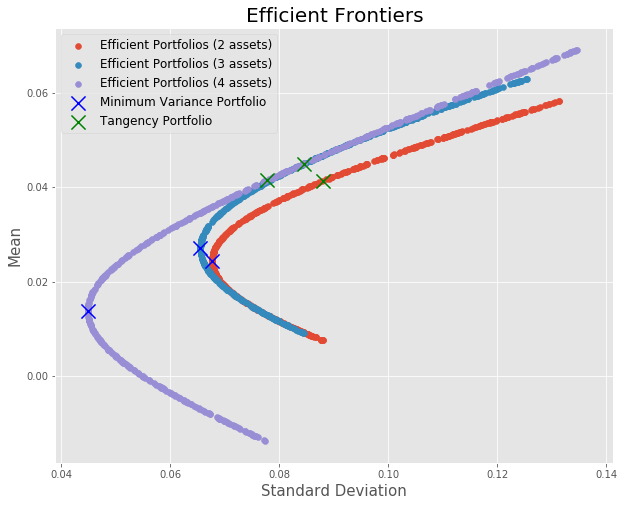

In [689]:
# used 500 efficient portfolios to trace out the efficient frontier
out1 = efficient_frontier(excess_real_returns[['S&P', 'T_Bond']], 500)

out2 = efficient_frontier(excess_real_returns[['S&P', 'T_Bond', 'Corporate_Bond']], 500)

out3 = efficient_frontier(excess_real_returns[['S&P', 'T_Bond', 'Corporate_Bond', 'Housing']], 500)



plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_title('Efficient Frontiers', fontdict={'fontsize':20})
ax.set_xlabel('Standard Deviation', fontdict={'fontsize':15})
ax.set_ylabel('Mean', fontdict={'fontsize':15})

ax.scatter(x=out1['std_list'], y=out1['mean_list'])
ax.scatter(x=out2['std_list'], y=out2['mean_list'])
ax.scatter(x=out3['std_list'], y=out3['mean_list'])

ax.scatter(x=out1['min_var_port']['std'], y=out1['min_var_port']['mean'], c='blue', marker='x', s=200)
ax.scatter(x=out1['max_sharpe_port']['std'], y=out1['max_sharpe_port']['mean'], c='green', marker='x', s=200)


ax.scatter(x=out2['min_var_port']['std'], y=out2['min_var_port']['mean'], c='blue', marker='x', s=200)
ax.scatter(x=out2['max_sharpe_port']['std'], y=out2['max_sharpe_port']['mean'], c='green', marker='x', s=200)


ax.scatter(x=out3['min_var_port']['std'], y=out3['min_var_port']['mean'], c='blue', marker='x', s=200)
ax.scatter(x=out3['max_sharpe_port']['std'], y=out3['max_sharpe_port']['mean'], c='green', marker='x', s=200)
ax.legend(['Efficient Portfolios (2 assets)', 'Efficient Portfolios (3 assets)', 'Efficient Portfolios (4 assets)',
           'Minimum Variance Portfolio', 'Tangency Portfolio'], fontsize='large')

### - Summary Statistics for Minimum Variance Portfolios

In [690]:
df_mvp_summary = pd.DataFrame({'two_assets':efficient_port(excess_real_returns[['S&P', 'T_Bond']])})
df_mvp_summary['three_assets'] = efficient_port(excess_real_returns[['S&P', 'T_Bond', 'Corporate_Bond']])
df_mvp_summary['four_assets'] = efficient_port(excess_real_returns[['S&P', 'T_Bond', 'Corporate_Bond', 'Housing']])
df_mvp_summary.iloc[:-1, :]
#.style.format('{:.2%}'))

[0.11351382 0.88648618]

[0.05351695 0.63833268 0.30815037]

[-0.00722977  0.34852579  0.12353267  0.53517131]



,two_assets,three_assets,four_assets
Mean,0.024,0.027,0.014
Std,0.068,0.066,0.045
Skewness,0.217,0.086,0.119
Kurtosis,-0.037,-0.027,-0.307


### - Summary Statistics for Tangency Portfolios

In [691]:
df_tangency_summary = pd.DataFrame({'two_assets':efficient_port(excess_real_returns[['S&P', 'T_Bond']],
                                                                       minimize_variance=False)})
df_tangency_summary['three_assets'] = efficient_port(excess_real_returns[['S&P', 'T_Bond', 'Corporate_Bond']],
                                                            minimize_variance=False)
df_tangency_summary['four_assets'] = efficient_port(excess_real_returns[['S&P', 'T_Bond', 'Corporate_Bond', 'Housing']],
                                                               minimize_variance=False)
df_tangency_summary.iloc[:-1, :]

[0.383789 0.616211]

[0.19728199 0.05537112 0.7473469 ]

[0.1761397  0.0584116  0.68291942 0.08252928]



,two_assets,three_assets,four_assets
Mean,0.041,0.045,0.041
Std,0.088,0.085,0.078
Skewness,-0.242,-0.495,-0.570
Kurtosis,0.025,0.497,0.617
